# Time Series Analysis - EWMA (Exponentially Weighted Moving Average)

## Overview
This notebook explores the use of Exponentially Weighted Moving Average (EWMA) for time series analysis and volatility forecasting.

### What is EWMA?
EWMA assigns exponentially decreasing weights to older observations, making it more responsive to recent changes than a simple moving average.

**Formula:** EWMA_t = λ × EWMA_{t-1} + (1-λ) × X_t
- λ (lambda/span): Smoothing factor (0 < λ < 1)
- Higher λ = more smoothing (slower to react)
- Lower λ = less smoothing (faster to react)

### Applications in Finance:
- Volatility estimation (RiskMetrics uses λ=0.94)
- Trend detection
- Noise reduction in price series
- Mean reversion strategies

---

## 1. Setup & Data Loading

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 7)

In [2]:
# Load macroeconomic dataset from statsmodels
# Contains US economic indicators (GDP, inflation, unemployment, etc.)
df = sm.datasets.macrodata.load_pandas().data

print("Dataset shape:", df.shape)
print("\nAvailable columns:")
print(df.columns.tolist())
print("\nFirst few rows:")
display(df.head())

# Dataset info
print("\nDataset period:")
print(f"From: Q{int(df['quarter'].iloc[0])}/{int(df['year'].iloc[0])}")
print(f"To: Q{int(df['quarter'].iloc[-1])}/{int(df['year'].iloc[-1])}")

Dataset shape: (203, 14)

Available columns:
['year', 'quarter', 'realgdp', 'realcons', 'realinv', 'realgovt', 'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']

First few rows:


,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19



Dataset period:
From: Q1/1959
To: Q3/2009


## 2. Data Preparation

In [8]:
# Create proper datetime index for time series analysis
# Combine year and quarter into a proper date

index = pd.date_range(start="1959-01-01", end="2009-09-30", freq="QE")
df.index = index

display(df.head())

# Select inflation rate as our target variable
# Inflation is a classic time series with trends and volatility
inflation = df['infl']

print("Inflation time series:")
print(f"Length: {len(inflation)} quarters")
print(f"Mean: {inflation.mean():.2f}%")
print(f"Std Dev: {inflation.std():.2f}%")
print(f"Min: {inflation.min():.2f}%")
print(f"Max: {inflation.max():.2f}%")

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


Inflation time series:
Length: 203 quarters
Mean: 3.96%
Std Dev: 3.25%
Min: -8.79%
Max: 14.62%


## 3. Visualize Raw Data

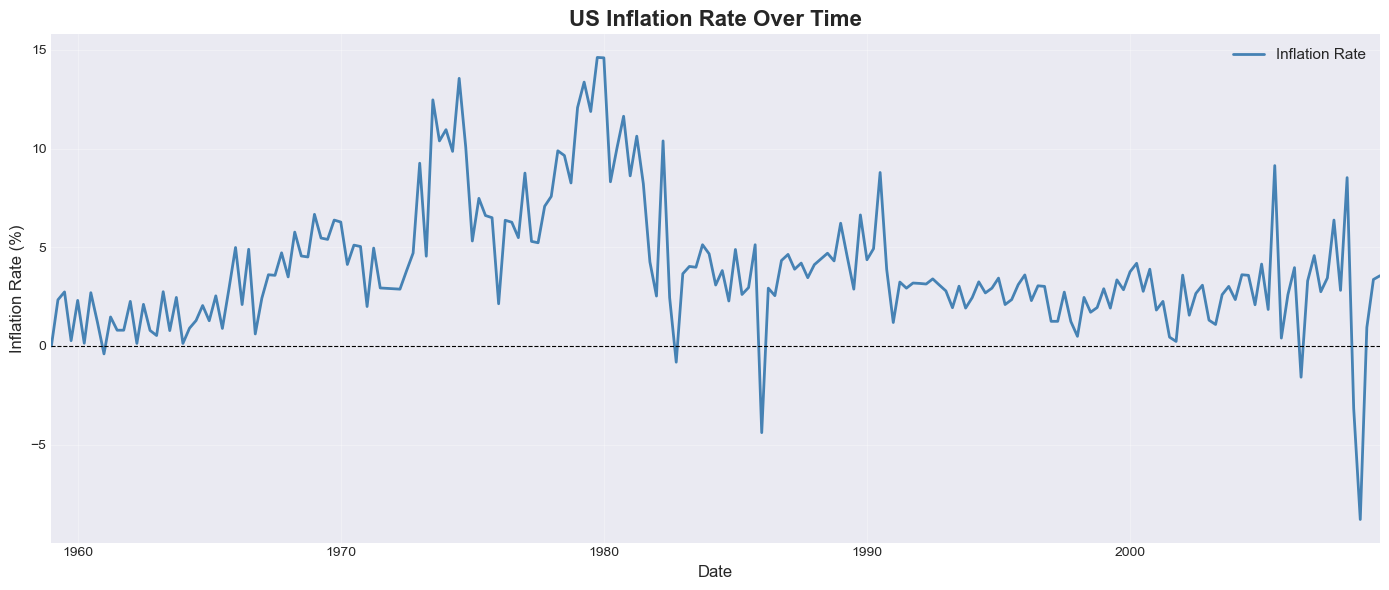


Key observations:
- High volatility in certain periods (e.g., 1970s oil crisis)
- Long-term trend changes visible
- Ideal candidate for EWMA smoothing


In [9]:
# Plot raw inflation data
fig, ax = plt.subplots(figsize=(14, 6))

inflation.plot(ax=ax, linewidth=2, label='Inflation Rate', color='steelblue')

ax.set_title('US Inflation Rate Over Time', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Inflation Rate (%)', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

# Observations
print("\nKey observations:")
print("- High volatility in certain periods (e.g., 1970s oil crisis)")
print("- Long-term trend changes visible")
print("- Ideal candidate for EWMA smoothing")

## 4. Apply EWMA with Different Spans

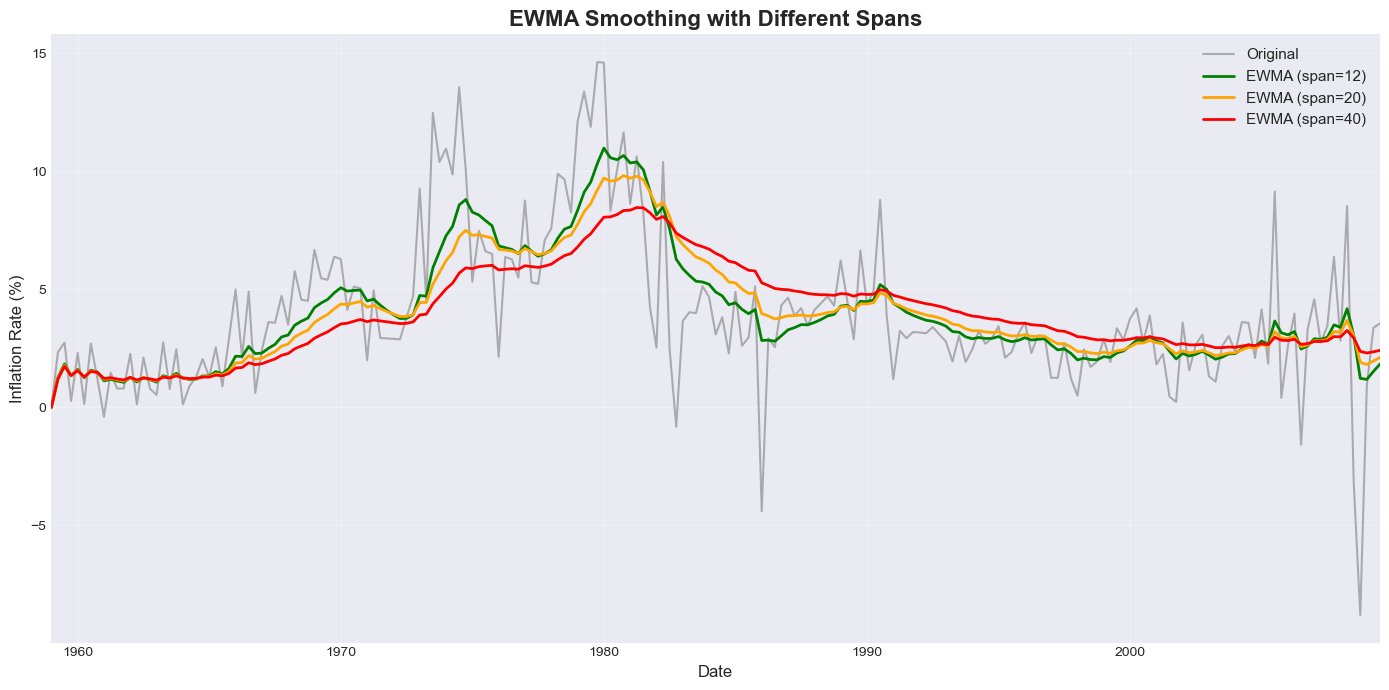


Interpretation:
- Span=12: Follows recent trends closely (responsive)
- Span=40: Smoother, captures long-term trends (stable)
- Trade-off: Responsiveness vs Noise reduction


In [11]:
# Calculate EWMA with different spans
# Span = number of periods for decay (higher span = more smoothing)
# Relationship: λ ≈ 1 - 2/(span+1)

ewma_12 = inflation.ewm(span=12).mean()  # ~1 year (4 quarters × 3)
ewma_20 = inflation.ewm(span=20).mean()  # ~5 years
ewma_40 = inflation.ewm(span=40).mean()  # ~10 years

# Plot original vs EWMA smoothed series
fig, ax = plt.subplots(figsize=(14, 7))

inflation.plot(ax=ax, label='Original', linewidth=1.5, alpha=0.6, color='gray')
ewma_12.plot(ax=ax, label='EWMA (span=12)', linewidth=2, color='green')
ewma_20.plot(ax=ax, label='EWMA (span=20)', linewidth=2, color='orange')
ewma_40.plot(ax=ax, label='EWMA (span=40)', linewidth=2, color='red')

ax.set_title('EWMA Smoothing with Different Spans', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Inflation Rate (%)', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Span=12: Follows recent trends closely (responsive)")
print("- Span=40: Smoother, captures long-term trends (stable)")
print("- Trade-off: Responsiveness vs Noise reduction")

## 5. EWMA for Volatility Estimation

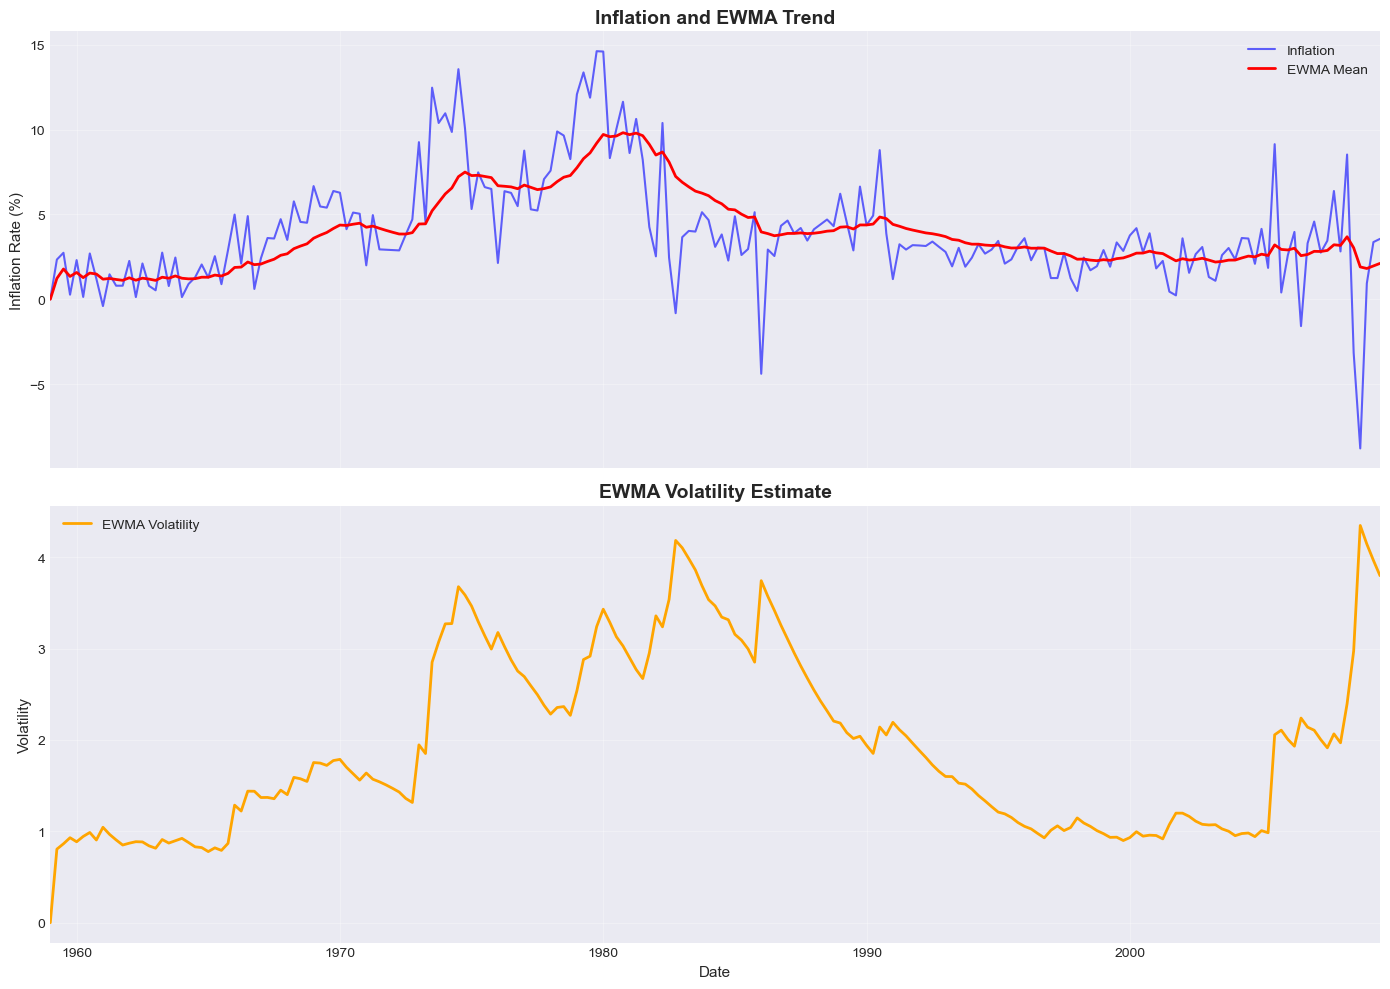


Volatility insights:
- Average volatility: 1.93
- Max volatility period: 2008-12-31 00:00:00
- Volatility clustering visible (high vol follows high vol)


In [12]:
# Calculate rolling volatility using EWMA
# Common in finance for estimating time-varying volatility

# First, calculate squared deviations from EWMA mean
ewma_mean = inflation.ewm(span=20).mean()
squared_deviations = (inflation - ewma_mean) ** 2

# Apply EWMA to squared deviations to get variance estimate
ewma_variance = squared_deviations.ewm(span=20).mean()
ewma_volatility = np.sqrt(ewma_variance)

# Plot volatility over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot 1: Inflation with EWMA
inflation.plot(ax=ax1, label='Inflation', alpha=0.6, color='blue')
ewma_mean.plot(ax=ax1, label='EWMA Mean', linewidth=2, color='red')
ax1.set_title('Inflation and EWMA Trend', fontsize=14, fontweight='bold')
ax1.set_ylabel('Inflation Rate (%)', fontsize=11)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: EWMA Volatility
ewma_volatility.plot(ax=ax2, label='EWMA Volatility', linewidth=2, color='orange')
ax2.set_title('EWMA Volatility Estimate', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Volatility', fontsize=11)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVolatility insights:")
print(f"- Average volatility: {ewma_volatility.mean():.2f}")
print(f"- Max volatility period: {ewma_volatility.idxmax()}")
print(f"- Volatility clustering visible (high vol follows high vol)")

## 6. Comparison: EWMA vs Simple Moving Average (SMA)

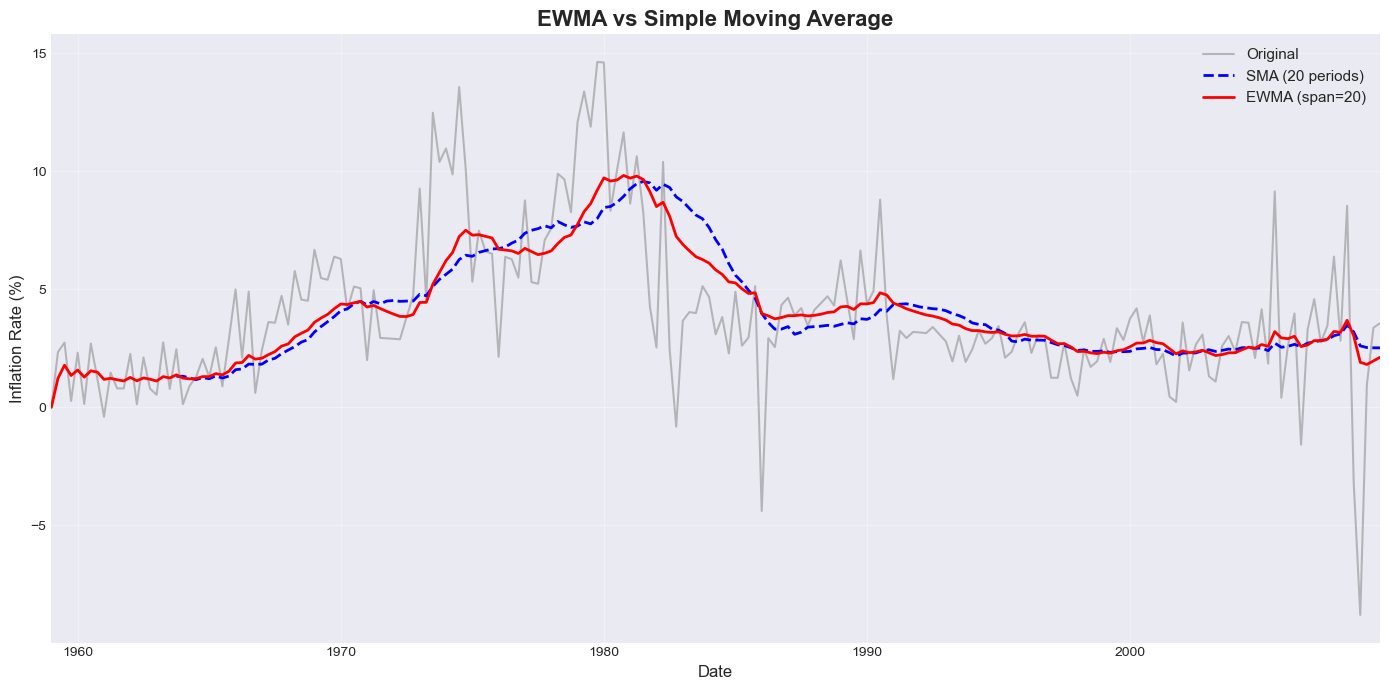


Key differences:
✓ EWMA: More responsive to recent changes (exponential weights)
✓ SMA: Equal weight to all observations (lagging indicator)
✓ EWMA: Better for volatile series and trend detection
✓ SMA: Simpler, more stable, better for noise reduction


In [13]:
# Compare EWMA with Simple Moving Average
# SMA gives equal weight to all observations in window
sma_20 = inflation.rolling(window=20).mean()
ewma_20 = inflation.ewm(span=20).mean()

# Plot comparison
fig, ax = plt.subplots(figsize=(14, 7))

inflation.plot(ax=ax, label='Original', linewidth=1.5, alpha=0.5, color='gray')
sma_20.plot(ax=ax, label='SMA (20 periods)', linewidth=2, color='blue', linestyle='--')
ewma_20.plot(ax=ax, label='EWMA (span=20)', linewidth=2, color='red')

ax.set_title('EWMA vs Simple Moving Average', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Inflation Rate (%)', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey differences:")
print("✓ EWMA: More responsive to recent changes (exponential weights)")
print("✓ SMA: Equal weight to all observations (lagging indicator)")
print("✓ EWMA: Better for volatile series and trend detection")
print("✓ SMA: Simpler, more stable, better for noise reduction")

## 7. Key Takeaways

### EWMA Advantages:
1. **Adaptive**: Gives more weight to recent observations
2. **Computationally efficient**: Requires less memory than rolling windows
3. **Industry standard**: Used in RiskMetrics, GARCH models
4. **Trend detection**: Better captures regime changes

### When to use EWMA:
- Volatility forecasting (VaR, CVaR)
- Trend-following strategies
- Time-varying parameter estimation
- Financial risk management


---
*Next steps: Explore ETS models for decomposition and ARIMA for forecasting*